<a href="https://www.kaggle.com/code/kaop11/digit-recognizer-optuna?scriptVersionId=206984596" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Digit Recognizer

In [1]:
import optuna
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import numpy as np

In [2]:
# Paths to the files
train_path = '/kaggle/input/digit-recognizer/train.csv'
test_path = '/kaggle/input/digit-recognizer/test.csv'

# Reading the CSV files into DataFrames
train_df = pd.read_csv(train_path)

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [4]:
train_df.shape

(42000, 785)

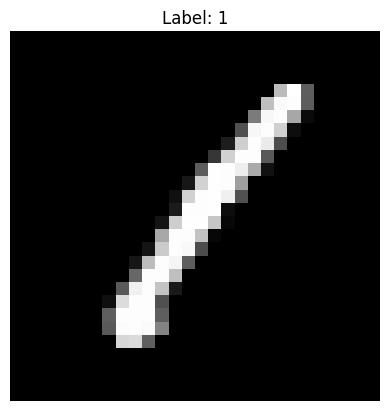

In [5]:
import matplotlib.pyplot as plt

# Convert a single row of pixels into a 28x28 image
def plot_digit(data, label=None):
    image = data.values.reshape(28, 28)
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}" if label is not None else "Test Image")
    plt.axis('off')
    plt.show()

# Visualize the first training image
plot_digit(train_df.iloc[0, 1:], label=train_df.iloc[0, 0])


In [6]:
# Separate the labels and features from the training data
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values

# Normalize the data and reshape it to (28, 28, 1) for each image
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255

# One-hot encode the labels
y_train = to_categorical(y_train, 10)

# For validation, we will split the training data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the model function with hyperparameters for Optuna to optimize
def create_model(trial):
    model = Sequential()

    # Hyperparameters
    filters_1 = trial.suggest_int('filters_1', 32, 64)  # Number of filters for the first conv layer
    filters_2 = trial.suggest_int('filters_2', 64, 128)  # Number of filters for the second conv layer
    dense_units = trial.suggest_int('dense_units', 128, 256)  # Number of units for the dense layer
    dropout_rate = trial.suggest_float('dropout', 0.3, 0.5)  # Dropout rate
    
    # Define the layers
    model.add(Conv2D(filters_1, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters_2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))  # Output layer for 10 classes

    # Hyperparameter for optimizer
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)  # Learning rate for Adam optimizer
    optimizer = Adam(learning_rate=learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Define the optimization function that Optuna will call
def objective(trial):
    model = create_model(trial)
    
    # Use early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)
    
    # Return the validation accuracy
    val_accuracy = history.history['val_accuracy'][-1]
    return val_accuracy

# Create and run the Optuna study
study = optuna.create_study(direction='maximize')  # We want to maximize validation accuracy
study.optimize(objective, n_trials=10)  # Run the optimization for 10 trials

# Get the best hyperparameters
print("Best hyperparameters:", study.best_params)


[I 2024-11-13 05:35:52,806] A new study created in memory with name: no-name-f56798be-3125-4031-b41f-cfd11839e2fe
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/tmp/ipykernel_23/97312083.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)  # Learning rate for Adam optimizer
I0000 00:00:1731476155.041338      67 service.cc:145] XLA service 0x7bafe40051a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731476155.04

Best hyperparameters: {'filters_1': 56, 'filters_2': 86, 'dense_units': 136, 'dropout': 0.4508713875933654, 'learning_rate': 0.0008911326426774908}


In [7]:
# Using the best hyperparameters found by Optuna
best_params = study.best_params

# Build the final model using these hyperparameters
model = Sequential()
model.add(Conv2D(best_params['filters_1'], (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(best_params['filters_2'], (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(best_params['dense_units'], activation='relu'))
model.add(Dropout(best_params['dropout']))
model.add(Dense(10, activation='softmax'))  # Output layer for 10 classes

# Compile the model with the optimized learning rate
model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Set up EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model on the full training data
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


Epoch 1/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8337 - loss: 0.5144 - val_accuracy: 0.9817 - val_loss: 0.0597
Epoch 2/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9731 - loss: 0.0885 - val_accuracy: 0.9864 - val_loss: 0.0441
Epoch 3/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9821 - loss: 0.0587 - val_accuracy: 0.9870 - val_loss: 0.0402
Epoch 4/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9844 - loss: 0.0506 - val_accuracy: 0.9881 - val_loss: 0.0358
Epoch 5/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9874 - loss: 0.0405 - val_accuracy: 0.9888 - val_loss: 0.0390
Epoch 6/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9879 - loss: 0.0397 - val_accuracy: 0.9905 - val_loss: 0.0319
Epoch 7/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9921 - loss: 0.0264 - val_accuracy: 0.9904 - val_loss: 0.0313
Epoch 8/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9918 - loss: 0.0253 - 

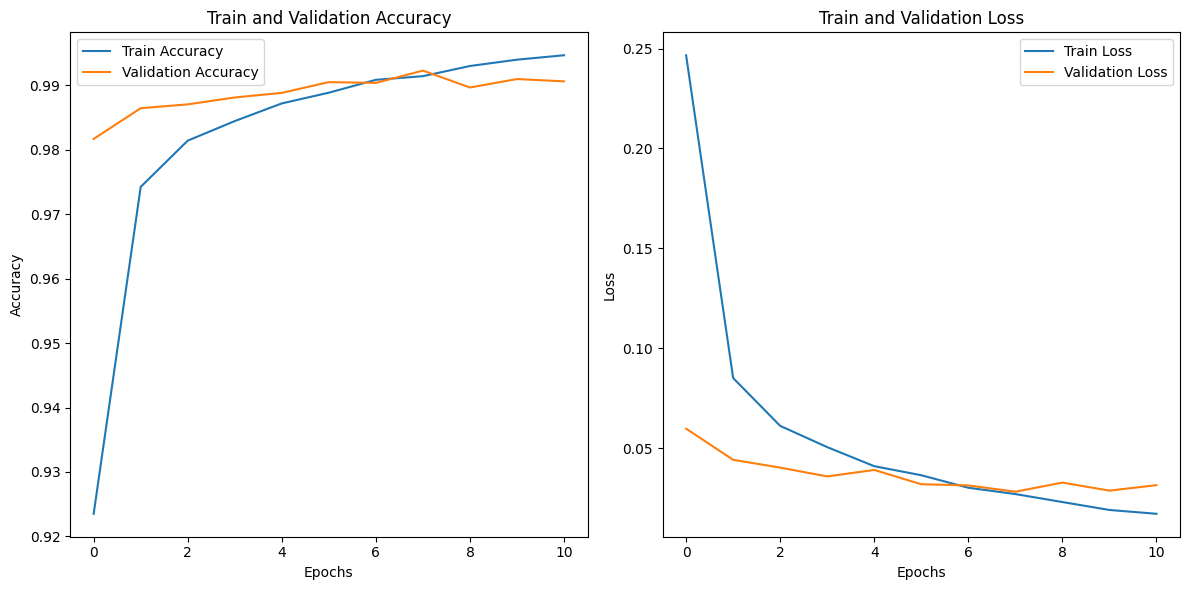

In [8]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result of model.fit() and contains training metrics

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
# Reading the test data
test_df = pd.read_csv(test_path)

# Preprocess the test data: Flatten and normalize
X_test = test_df.values.reshape(-1, 28, 28, 1).astype('float32') / 255

# Predicting with the trained model
y_pred = model.predict(X_test)

# Convert predictions from probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Prepare for submission (if applicable)
# If you need to create a submission file, you can format it like this:
submission_df = pd.DataFrame({'ImageId': np.arange(1, len(y_pred_labels) + 1), 'Label': y_pred_labels})

# Save the submission file as a CSV
submission_df.to_csv('submission.csv', index=False)

print("Submission file created: submission.csv")


875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Submission file created: submission.csv
